In [ ]:
!pip install networkx
!pip install powerlaw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import itertools
import math
import networkx as nx
from networkx.utils import create_random_state

# create a random seed
seed = create_random_state(None)

def StochasticBlockModel(sizes, p, threshold, k, nodelist=None, seed=seed):
    if nodelist is not None:
        if len(nodelist) != sum(sizes):
            raise nx.NetworkXException("'nodelist' and 'sizes' do not match.")
        if len(nodelist) != len(set(nodelist)):
            raise nx.NetworkXException("nodelist contains duplicate.")
    else:
        nodelist = range(0, sum(sizes))

    block_range = range(len(sizes))
    g = nx.Graph()
    block_iter = itertools.combinations_with_replacement(block_range, 2)
    
    # Split nodelist in a partition (list of sets).
    size_cumsum = [sum(sizes[0:x]) for x in range(0, len(sizes) + 1)]
    g.graph["partition"] = [
        set(nodelist[size_cumsum[x] : size_cumsum[x + 1]])
        for x in range(0, len(size_cumsum) - 1)
    ]
    # Setup nodes and graph name
    for block_id, nodes in enumerate(g.graph["partition"]):
        for node in nodes:
            g.add_node(node, block=block_id)

    g.name = "stochastic_block_model"

    # Test for edge existence
    parts = g.graph["partition"]
    for i, j in block_iter:
        if i == j:
            edges = itertools.combinations(parts[i], 2)
            for e in edges:
                if seed.random() < p[i][j]:
                    g.add_edge(*e)
                    p[i][j] += threshold
                    if p[i][j] > threshold*k:
                      p[i][j] = threshold*k
        else:
            edges = itertools.product(parts[i], parts[j])
            for e in edges:
                if seed.random() < p[i][j]:
                    g.add_edge(*e)  
                    p[i][j] -= threshold
                    if p[i][j] < threshold/k:
                      p[i][j] = threshold/k
    return g

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import community
import random

# Define the triadic closure function
def TriadicClosure(G, threshold, N):
    for u in G.nodes():
        for v in G.nodes():
            if u == v:
                continue
            u_neighbors = set(G.neighbors(u))
            v_neighbors = set(G.neighbors(v))
            u_deg = G.degree(u)
            v_deg = G.degree(v)
            if u_deg + v_deg == 0:
              continue
            common_neighbors = u_neighbors.intersection(v_neighbors)
            k = len(common_neighbors)
            p = (2*k)/(u_deg+v_deg) 
            if p >= 1:
              p = 1
            if np.random.random() < p:
                G.add_edge(u, v)


In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import community
import math
import random

def ConstantPreferential(G, new_node, iter):
    # calculate the degree distribution
    degrees = [G.degree(node) for node in G.nodes()]
    total_degree = sum(degrees)
    prob = [degree / total_degree for degree in degrees]

    existing_node = random.choices(list(G.nodes()), weights=prob)[0]
    while (new_node == existing_node or G.degree(existing_node) == 0):
      existing_node = random.choices(list(G.nodes()), weights=prob)[0]
    G.add_edge(new_node, existing_node)
    iter = iter - 1
    
    # repeat m times to add more edges
    while iter > 0:
      for node in G.neighbors(existing_node):
        if (node != new_node and not G.has_edge(new_node, node)):
          G.add_edge(new_node, node)
          iter = iter - 1
          if iter <= 0:
            break
      if iter <= 0:
        break
      # calculate the degree distribution
      degrees = [G.degree(node) for node in G.nodes()]
      total_degree = sum(degrees)
      prob = [degree / total_degree for degree in degrees]

      existing_node = random.choices(list(G.nodes()), weights=prob)[0]
      while (new_node == existing_node or G.degree(existing_node) == 0 or G.has_edge(new_node, existing_node)):
        existing_node = random.choices(list(G.nodes()), weights=prob)[0]
      G.add_edge(new_node, existing_node)
      iter = iter - 1

def VariablePreferential(G, new_node, iter):
    # calculate the degree distribution
    degrees = [G.degree(node) for node in G.nodes()]
    total_degree = sum(degrees)
    prob = [degree / total_degree for degree in degrees]

    existing_node = random.choices(list(G.nodes()), weights=prob)[0]
    while (new_node == existing_node or G.degree(existing_node) == 0):
      existing_node = random.choices(list(G.nodes()), weights=prob)[0]
    G.add_edge(new_node, existing_node)

    iter = iter - 1
    # repeat m times to add more edges
    while iter > 0:
      ndegrees = [G.degree(node) for node in G.neighbors(existing_node)]
      ntotal_degree = sum(ndegrees)
      nprob = [degree / ntotal_degree for degree in ndegrees]
      neighbor = random.choices(list(G.neighbors(existing_node)), weights=nprob)[0]     
      while (new_node == neighbor):
        neighbor = random.choices(list(G.neighbors(existing_node)), weights=nprob)[0]
      G.add_edge(new_node, neighbor)
      iter = iter - 1
      if iter == 1:
        ndegrees = [G.degree(node) for node in G.neighbors(existing_node)]
        ntotal_degree = sum(ndegrees)
        nprob = [degree / ntotal_degree for degree in ndegrees]
        neighbor = random.choices(list(G.neighbors(existing_node)), weights=nprob)[0]     
        while (new_node == neighbor or G.has_edge(new_node, neighbor)):
          neighbor = random.choices(list(G.neighbors(existing_node)), weights=nprob)[0]
        G.add_edge(new_node, neighbor)
        iter = iter - 1
      if iter <=0:
        break

      # calculate the degree distribution
      degrees = [G.degree(node) for node in G.nodes()]
      total_degree = sum(degrees)
      prob = [degree / total_degree for degree in degrees]
 
      existing_node = random.choices(list(G.nodes()), weights=prob)[0]
      while (new_node == existing_node or G.degree(existing_node) == 0):
        existing_node = random.choices(list(G.nodes()), weights=prob)[0]
      G.add_edge(new_node, existing_node)
      iter = iter - 1

Average clustering coefficient: 0.3769400168271035
Average degree: 44.2444733420026
Number of communities: 7


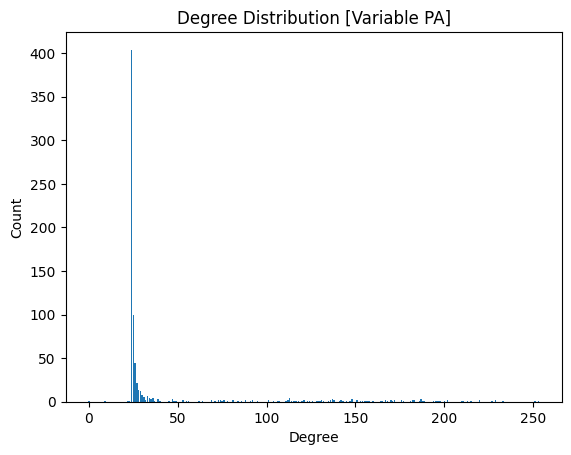

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import community
import math
import random

N = 769 # Max degree of a Node possible (Nodes - 1) 
k = int(math.sqrt(N)) # sqroot(n), the number of blocks
I = int(math.sqrt(k)) # sqroot(k) to k, number of triadic closure runs
n = k*I # 10% of N, the number of nodes in our SBM
d = 46 # average degree
threshold = d/N

# Generate the SBM graph
block_sizes = [n // k] * k
p = np.ones((k, k)) * np.random.uniform(low=threshold/I, high=threshold, size=(k, k))
np.fill_diagonal(p, np.random.uniform(low=threshold, high=threshold*I, size=k))
p = np.clip(p, 0, 1)
p = (p + p.T) / 2  # make p symmetrical

G = StochasticBlockModel(block_sizes, p, threshold, k)

block_membership = [0] * n
for i in range(k):
    block_membership[i * (n // k):(i + 1) * (n // k)] = [i] * (n // k)

# Create a dictionary of labels, where the keys are the node IDs and the values are the block numbers
labels = {}
for i in range(n):
    labels[i] = block_membership[i]

nx.set_node_attributes(G, labels, 'block')

for i in range(1):
  # Call the triadic closure function
  TriadicClosure(G, threshold, N)

newNodes = N-n
newLinks = d//2 + 1

for i in range(newNodes):
    iter = newLinks
    new_node = i + n
    G.add_node(new_node)

    # 0 for Constant / 1 for Variable
    PrefThresh = 0

    if np.random.random() < PrefThresh:
      VariablePreferential(G, new_node, iter)
    else:
      ConstantPreferential(G, new_node, iter)

# # Draw the graph with different colors for each block
# pos = nx.kamada_kawai_layout(G)
# nx.draw(G, pos, node_size=1)

# Calculate the average clustering coefficient for the graph
avg_clustering = nx.average_clustering(G)
print(f"Average clustering coefficient: {avg_clustering}")

# Calculate the diameter of the graph
if nx.is_connected(G):
  diameter = nx.diameter(G)
  print(f"The diameter of the graph is {diameter}.")

# find the average degree
avg_degree = sum(dict(G.degree()).values()) / len(G)
print("Average degree:", avg_degree)

# find the communities
communities = list(community.greedy_modularity_communities(G))
print("Number of communities:", len(communities))

# find the degree distribution
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = dict()
for degree in degree_sequence:
    if degree in degree_count:
        degree_count[degree] += 1
    else:
        degree_count[degree] = 1
degrees = sorted(degree_count.keys())
degree_counts = [degree_count[degree] for degree in degrees]

# # plot the degree distribution
plt.bar(degrees, degree_counts)
plt.title("Degree Distribution [Variable PA]")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()



The Erdos-Renyi graph has 769 nodes and 16825 edges.
Average clustering coefficient: 0.05692583394882846
The diameter of the graph is 3.
Average degree: 43.75812743823147
Number of communities: 5


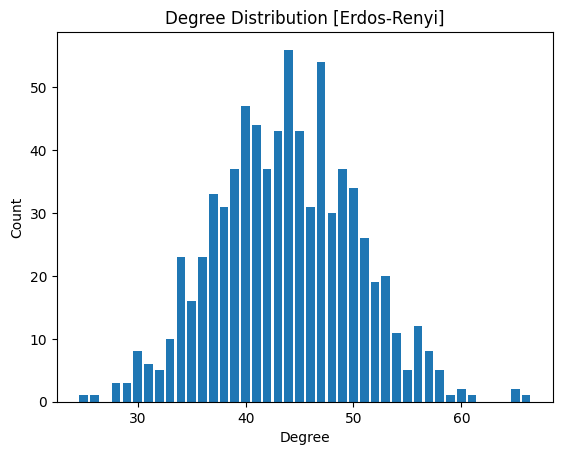

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import community
import math
import random

n = 769  # number of nodes
p = 0.057  # probability of edge creation

G = nx.erdos_renyi_graph(n, p)

print(f"The Erdos-Renyi graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Calculate the average clustering coefficient for the graph
avg_clustering = nx.average_clustering(G)
print(f"Average clustering coefficient: {avg_clustering}")

# Calculate the diameter of the graph
if nx.is_connected(G):
  diameter = nx.diameter(G)
  print(f"The diameter of the graph is {diameter}.")

# find the average degree
avg_degree = sum(dict(G.degree()).values()) / len(G)
print("Average degree:", avg_degree)

# find the communities
communities = list(community.greedy_modularity_communities(G))
print("Number of communities:", len(communities))

# find the degree distribution
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = dict()
for degree in degree_sequence:
    if degree in degree_count:
        degree_count[degree] += 1
    else:
        degree_count[degree] = 1
degrees = sorted(degree_count.keys())
degree_counts = [degree_count[degree] for degree in degrees]

# # plot the degree distribution
plt.bar(degrees, degree_counts)
plt.title("Degree Distribution [Erdos-Renyi]")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

The Barabasi-Albert graph has 769 nodes and 17158 edges.
Average clustering coefficient: 0.12503757232374363
The diameter of the graph is 3.
Average degree: 44.62418725617685
Number of communities: 5


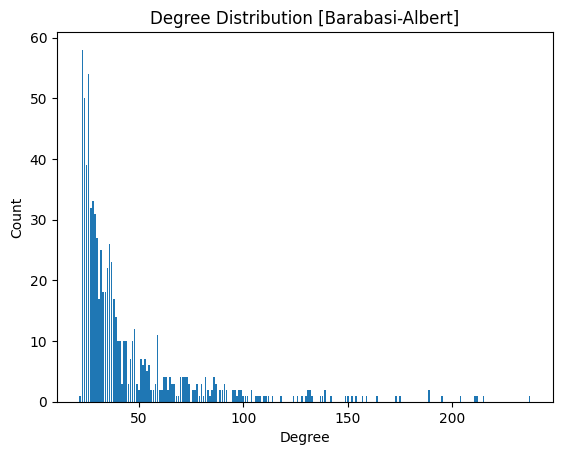

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import community
import math
import random

n = 769  # number of nodes
m = 23  # number of edges to attach from a new node to existing nodes

G = nx.barabasi_albert_graph(n, m)

print(f"The Barabasi-Albert graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Calculate the average clustering coefficient for the graph
avg_clustering = nx.average_clustering(G)
print(f"Average clustering coefficient: {avg_clustering}")

# Calculate the diameter of the graph
if nx.is_connected(G):
  diameter = nx.diameter(G)
  print(f"The diameter of the graph is {diameter}.")

# find the average degree
avg_degree = sum(dict(G.degree()).values()) / len(G)
print("Average degree:", avg_degree)

# find the communities
communities = list(community.greedy_modularity_communities(G))
print("Number of communities:", len(communities))

# find the degree distribution
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = dict()
for degree in degree_sequence:
    if degree in degree_count:
        degree_count[degree] += 1
    else:
        degree_count[degree] = 1
degrees = sorted(degree_count.keys())
degree_counts = [degree_count[degree] for degree in degrees]

# # plot the degree distribution
plt.bar(degrees, degree_counts)
plt.title("Degree Distribution [Barabasi-Albert]")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

The Watts-Strogatz graph has 769 nodes and 16149 edges.
Average clustering coefficient: 0.13010231314108525
The diameter of the graph is 3.
Average degree: 42.0
Number of communities: 3


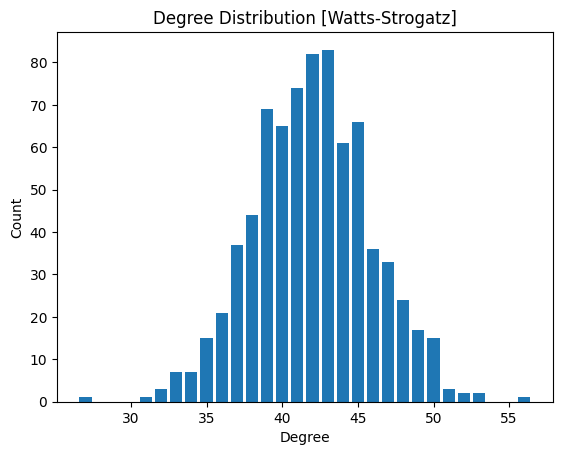

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import community
import math
import random

n = 769
k = 43
p = 0.5

G = nx.watts_strogatz_graph(n, k, p)

print(f"The Watts-Strogatz graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Calculate the average clustering coefficient for the graph
avg_clustering = nx.average_clustering(G)
print(f"Average clustering coefficient: {avg_clustering}")

# Calculate the diameter of the graph
if nx.is_connected(G):
  diameter = nx.diameter(G)
  print(f"The diameter of the graph is {diameter}.")

# find the average degree
avg_degree = sum(dict(G.degree()).values()) / len(G)
print("Average degree:", avg_degree)

# find the communities
communities = list(community.greedy_modularity_communities(G))
print("Number of communities:", len(communities))

# find the degree distribution
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = dict()
for degree in degree_sequence:
    if degree in degree_count:
        degree_count[degree] += 1
    else:
        degree_count[degree] = 1
degrees = sorted(degree_count.keys())
degree_counts = [degree_count[degree] for degree in degrees]

# # plot the degree distribution
plt.bar(degrees, degree_counts)
plt.title("Degree Distribution [Watts-Strogatz]")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

The R-MAT graph has 769 nodes and 16500 edges.
Average clustering coefficient: 0.05607009528050399
The diameter of the graph is 3.
Average degree: 42.91287386215865
Number of communities: 4


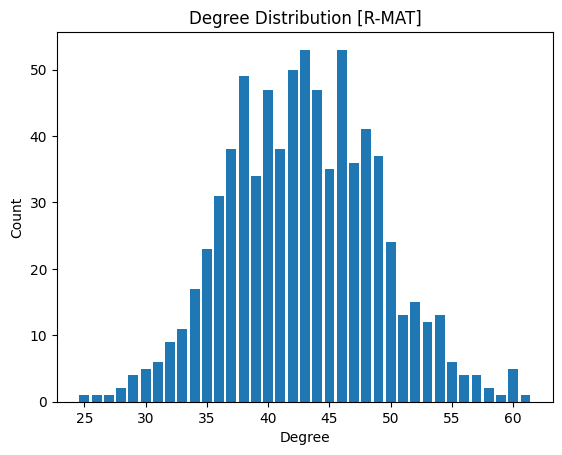

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import community
import math
import random

n = 769  # number of nodes
m = 16500  # number of edges

G = nx.generators.random_graphs.gnm_random_graph(n, m)

print(f"The R-MAT graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Calculate the average clustering coefficient for the graph
avg_clustering = nx.average_clustering(G)
print(f"Average clustering coefficient: {avg_clustering}")

# Calculate the diameter of the graph
if nx.is_connected(G):
  diameter = nx.diameter(G)
  print(f"The diameter of the graph is {diameter}.")

# find the average degree
avg_degree = sum(dict(G.degree()).values()) / len(G)
print("Average degree:", avg_degree)

# find the communities
communities = list(community.greedy_modularity_communities(G))
print("Number of communities:", len(communities))

# find the degree distribution
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = dict()
for degree in degree_sequence:
    if degree in degree_count:
        degree_count[degree] += 1
    else:
        degree_count[degree] = 1
degrees = sorted(degree_count.keys())
degree_counts = [degree_count[degree] for degree in degrees]

# # plot the degree distribution
plt.bar(degrees, degree_counts)
plt.title("Degree Distribution [R-MAT]")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()